Doc2vec from scratch in PyTorch
===============================

Here we are implementing this useful algorithm with a library we know and trust. With luck this will be more accessible than reading the papers but more in-depth than typical "install gensim and just do what I say" tutorials, and still easy to understand for anyone whose maths skills have atrophied to nothing (like me). This is all based on the great work by [Nejc Ilenic](https://github.com/ilenic/paragraph-vectors) and reading the referenced papers.

The basic form of `word2vec` (and so `doc2vec`) is that it is a classifier trained to predict the missing word in a context. So given sentences like "the cat _ on the mat" it should predict "sat", and so learn a useful representation of words. We can then extract the internal weights and re-use them as "word embeddings", vectors giving each word a position in N-dimensional space that is hopefully close to similar words and an appropriate distance from related words. 

`doc2vec` or "Paragraph vectors" extends the `word2vec` idea by simply adding a document id to each context. This helps the network learn associations between contexts (but of course produces less generalizable vectors).

First we need to load the data. We'll by overfitting on a tiny dataset just to check all the parts fit together.

In [1]:
import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")

example_df = pd.read_csv("data/example.csv")

def tokenize_text(df):
    df["tokens"] = df.text.str.lower().str.strip().apply(lambda x: [token.text.strip() for token in nlp(x) if token.text.isalnum()])
    return df

example_df = tokenize_text(example_df)

example_df

,text,tokens
0,"In the week before their departure to Arrakis,...","[in, the, week, before, their, departure, to, ..."
1,"It was a warm night at Castle Caladan, and the...","[it, was, a, warm, night, at, castle, caladan,..."
2,The old woman was let in by the side door down...,"[the, old, woman, was, let, in, by, the, side,..."
3,"By the half-light of a suspensor lamp, dimmed ...","[by, the, half, light, of, a, suspensor, lamp,..."


We will need to construct a vocabulary so we can reference every word by an ID.

In [2]:
from collections import Counter

class Vocab:
    def __init__(self, all_tokens, min_count=2):
        self.min_count = min_count
        self.freqs = {t:n for t, n in Counter(all_tokens).items() if n >= min_count}
        self.words = sorted(self.freqs.keys())
        self.word2idx = {w: i for i, w in enumerate(self.words)}
        
vocab = Vocab([tok for tokens in example_df.tokens for tok in tokens], min_count=1)

print(f"Dataset comprises {len(example_df)} documents and {len(vocab.words)} unique words (over the limit of {vocab.min_count} occurrences)")

Dataset comprises 4 documents and 106 unique words (over the limit of 1 occurrences)


Words that appear extremely rarely can harm performance, so we add a simple mechanism to strip those out.

In [3]:
def clean_tokens(df, vocab):
    df["length"] = df.tokens.apply(len)
    df["clean_tokens"] = df.tokens.apply(lambda x: [t for t in x if t in vocab.freqs.keys()])
    df["clean_length"] = df.clean_tokens.apply(len)
    return df

example_df = clean_tokens(example_df, vocab)
example_df[:5]

,text,tokens,length,clean_tokens,clean_length
0,"In the week before their departure to Arrakis,...","[in, the, week, before, their, departure, to, ...",32,"[in, the, week, before, their, departure, to, ...",32
1,"It was a warm night at Castle Caladan, and the...","[it, was, a, warm, night, at, castle, caladan,...",39,"[it, was, a, warm, night, at, castle, caladan,...",39
2,The old woman was let in by the side door down...,"[the, old, woman, was, let, in, by, the, side,...",34,"[the, old, woman, was, let, in, by, the, side,...",34
3,"By the half-light of a suspensor lamp, dimmed ...","[by, the, half, light, of, a, suspensor, lamp,...",53,"[by, the, half, light, of, a, suspensor, lamp,...",53


The difficulty with our "the cat _ on the mat" problem is that the missing word could be any one in the vocabulary V and so the network would have |V| outputs for each input e.g. a huge vector containing zero for every word in the vocabulary and some positive number for "sat" if the network was perfectly trained. For calculating loss we need to turn that into a probabilty distribution, i.e. _softmax_ it. Computing the softmax for such a large vector is expensive.

So the trick (one of many possible) we will use is _Noise Contrastive Estimation (NCE)_. We change our "the cat _ on the mat" problem into a multiple choice problem, asking the network to choose between "sat" and some random wrong answers like "hopscotch" and "luxuriated". This is easier to compute the softmax for since it's now a binary classifier (right or wrong answer) and the output is simply of a vector of size 1 + k where k is the number of random incorrect options.

Happily, this alternative problem still learns equally useful word representations. We just need to adjust the examples and the loss function. There is a simplified version of the NCE loss function called _Negative Sampling (NEG)_ that we can use here.

[Notes on Noise Contrastive Estimation and Negative Sampling (C. Dyer)](https://arxiv.org/abs/1410.8251) explains the derivation of the NCE and NEG loss functions.

When we implement the loss function, we assume that the first element in a samples/scores vector is the score for the positive sample and the rest are negative samples. This convention saves us from having to pass around an auxiliary vector indicating which sample was positive.

In [4]:
import torch.nn as nn

class NegativeSampling(nn.Module):
    def __init__(self):
        super(NegativeSampling, self).__init__()
        self.log_sigmoid = nn.LogSigmoid()
    def forward(self, scores):
        batch_size = scores.shape[0]
        n_negative_samples = scores.shape[1] - 1   # TODO average or sum the negative samples? Summing seems to be correct by the paper
        positive = self.log_sigmoid(scores[:,0])
        negatives = torch.sum(self.log_sigmoid(-scores[:,1:]), dim=1)
        return -torch.sum(positive + negatives) / batch_size  # average for batch

loss = NegativeSampling()

It's helpful to play with some values to reassure ourselves that this function does the right thing.

In [5]:
import torch 

data = [[[1, -1, -1, -1]],  # this dummy data uses -1 to 1, but the real model is unconstrained
        [[0.5, -1, -1, -1]],
        [[0, -1, -1, -1]],
        [[0, 0, 0, 0]],
        [[0, 0, 0, 1]],
        [[0, 1, 1, 1]],
        [[0.5, 1, 1, 1]],
        [[1, 1, 1, 1]]]

loss_df = pd.DataFrame(data, columns=["scores"])
loss_df["loss"] = loss_df.scores.apply(lambda x: loss(torch.FloatTensor([x])))

loss_df

,scores,loss
0,"[1, -1, -1, -1]",tensor(1.2530)
1,"[0.5, -1, -1, -1]",tensor(1.4139)
2,"[0, -1, -1, -1]",tensor(1.6329)
3,"[0, 0, 0, 0]",tensor(2.7726)
4,"[0, 0, 0, 1]",tensor(3.3927)
5,"[0, 1, 1, 1]",tensor(4.6329)
6,"[0.5, 1, 1, 1]",tensor(4.4139)
7,"[1, 1, 1, 1]",tensor(4.2530)


Higher scores for the positive sample (always the first element) reduce the loss but higher scores for the negative samples increase the loss. This looks like the right behaviour.

With that in the bag, let's look at creating training data. The general idea is to create a set of examples where each example has:

- doc id
- sample ids - a collection of the target token and some noise tokens
- context ids - tokens before and after the target token

e.g. If our context size was 2, the first example from the above dataset would be:

```
{"doc_id": 0,
 "sample_ids": [word2idx[x] for x in ["week", "random-word-from-vocab", "random-word-from-vocab"...],
 "context_ids": [word2idx[x] for x in ["in", "the", "before", "their"]]}
 ```
 
 The random words are chosen according to a probability distribution:
 
 > a unigram distribution raised to the 3/4rd power, as proposed by T. Mikolov et al. in Distributed Representations of Words and Phrases and their Compositionality

This has the effect of slightly increasing the relative probability of rare words (look at the graph of `y=x^0.75` below and see how the lower end is raised above `y=x`).

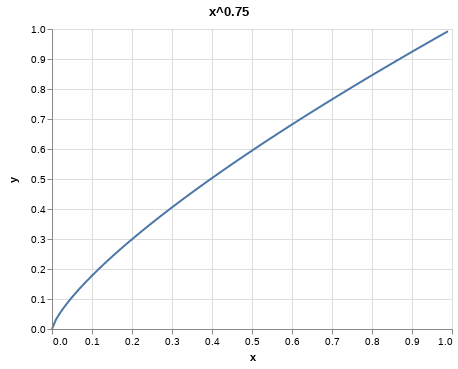

In [6]:
import altair as alt
import numpy as np

data = pd.DataFrame(zip(np.arange(0,1,0.01), np.power(np.arange(0,1,0.01), 0.75)), columns=["x", "y"])
alt.Chart(data, title="x^0.75").mark_line().encode(x="x", y="y")

In [7]:
import numpy as np

class NoiseDistribution:
    def __init__(self, vocab):
        self.probs = np.array([vocab.freqs[w] for w in vocab.words])
        self.probs = np.power(self.probs, 0.75)
        self.probs /= np.sum(self.probs)
    def sample(self, n):
        "Returns the indices of n words randomly sampled from the vocabulary."
        return np.random.choice(a=self.probs.shape[0], size=n, p=self.probs)
        
noise = NoiseDistribution(vocab)

With this distribution, we advance through the documents creating examples. Note that we are always putting the positive sample first in the samples vector, following the convention the loss function expects.

In [8]:
import torch

def example_generator(df, context_size, noise, n_negative_samples, vocab):
    for doc_id, doc in df.iterrows():
        for i in range(context_size, len(doc.clean_tokens) - context_size):
            positive_sample = vocab.word2idx[doc.clean_tokens[i]]
            sample_ids = noise.sample(n_negative_samples).tolist()
            # Fix a wee bug - ensure negative samples don't accidentally include the positive
            sample_ids = [sample_id if sample_id != positive_sample else -1 for sample_id in sample_ids]
            sample_ids.insert(0, positive_sample)                
            context = doc.clean_tokens[i - context_size:i] + doc.clean_tokens[i + 1:i + context_size + 1]
            context_ids = [vocab.word2idx[w] for w in context]
            yield {"doc_ids": torch.tensor(doc_id),  # we use plural here because it will be batched
                   "sample_ids": torch.tensor(sample_ids), 
                   "context_ids": torch.tensor(context_ids)}
            
examples = example_generator(example_df, context_size=5, noise=noise, n_negative_samples=5, vocab=vocab)

Now we package this up as a good old PyTorch dataset and dataloader.

In [9]:
from torch.utils.data import Dataset, DataLoader

class NCEDataset(Dataset):
    def __init__(self, examples):
        self.examples = list(examples)  # just naively evaluate the whole damn thing - suboptimal!
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, index):
        return self.examples[index]
    
dataset = NCEDataset(examples)
dataloader = DataLoader(dataset, batch_size=2, drop_last=True, shuffle=True)  # TODO bigger batch size when not dummy data

It's going to also be useful to have a way to convert batches back to a readable form for debugging, so we add a helper function.

In [10]:
def describe_batch(batch, vocab):
    results = []
    for doc_id, context_ids, sample_ids in zip(batch["doc_ids"], batch["context_ids"], batch["sample_ids"]):
        context = [vocab.words[i] for i in context_ids]
        context.insert(len(context_ids) // 2, "____")
        samples = [vocab.words[i] for i in sample_ids]
        result = {"doc_id": doc_id,
                  "context": " ".join(context), 
                  "context_ids": context_ids, 
                  "samples": samples, 
                  "sample_ids": sample_ids}
        results.append(result)
    return results

describe_batch(next(iter(dataloader)), vocab)

[{'doc_id': tensor(3),
  'context': 'a witch shadow hair like ____ spiderwebs hooded round darkness of',
  'context_ids': tensor([  0, 104,  79,  44,  59,  84,  51,  75,  27,  66]),
  'samples': ['matted', 'as', 'had', 'twenty', 'side', 'in'],
  'sample_ids': tensor([60, 10, 43, 94, 82, 52])},
 {'doc_id': tensor(2),
  'context': 'in by the side door ____ the vaulted passage by paul',
  'context_ids': tensor([52, 19, 91, 82, 30, 91, 96, 69, 19, 70]),
  'samples': ['down', 'him', 'shape', 'near', 'reached', 'boy'],
  'sample_ids': tensor([31, 48, 80, 63, 73, 17])}]

Let's jump into creating the model itself. There isn't much to it - we multiply the input paragraph and word matrices by the output layer. Combining the paragraph and word matrices is done by summing here, but it could also be done by concatenating the inputs. The original paper actually found concatenation works better, perhaps because summing loses word order information.

In [11]:
import torch.nn as nn

class DistributedMemory(nn.Module):
    def __init__(self, vec_dim, n_docs, n_words):
        super(DistributedMemory, self).__init__()
        self.paragraph_matrix = nn.Parameter(torch.randn(n_docs, vec_dim))
        self.word_matrix = nn.Parameter(torch.randn(n_words, vec_dim))
        self.outputs = nn.Parameter(torch.zeros(vec_dim, n_words))
    
    def forward(self, doc_ids, context_ids, sample_ids):
                                                                               # first add doc ids to context word ids to make the inputs
        inputs = torch.add(self.paragraph_matrix[doc_ids,:],                   # (batch_size, vec_dim)
                           torch.sum(self.word_matrix[context_ids,:], dim=1))  # (batch_size, 2x context, vec_dim) -> sum to (batch_size, vec_dim)
                                                                               #
                                                                               # select the subset of the output layer for the NCE test
        outputs = self.outputs[:,sample_ids]                                   # (vec_dim, batch_size, n_negative_samples + 1)
                                                                               #
        return torch.bmm(inputs.unsqueeze(dim=1),                              # then multiply with some munging to make the tensor shapes line up 
                         outputs.permute(1, 0, 2)).squeeze()                   # -> (batch_size, n_negative_samples + 1)

model = DistributedMemory(vec_dim=50,
                          n_docs=len(example_df),
                          n_words=len(vocab.words))

Let's take it for a spin!

In [12]:
with torch.no_grad():
    logits = model.forward(**next(iter(dataloader)))
logits

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

Oh yeah, the output layer was initialized with zeros. Time to bash out a standard issue PyTorch training loop.

In [13]:
from tqdm import tqdm, trange
from torch.optim import Adam  # ilenic uses Adam, but gensim uses plain SGD
import numpy as np

def train(model, dataloader, epochs=40, lr=1e-3):
    optimizer = Adam(model.parameters(), lr=lr)
    training_losses = []
    try:
        for epoch in trange(epochs, desc="Epochs"):
            epoch_losses = []
            for batch in dataloader:
                model.zero_grad()
                logits = model.forward(**batch)
                batch_loss = loss(logits)
                epoch_losses.append(batch_loss.item())
                batch_loss.backward()
                optimizer.step()
            training_losses.append(np.mean(epoch_losses))
    except KeyboardInterrupt:
        print(f"Interrupted on epoch {epoch}!")
    finally:
        return training_losses

Now we'll sanity check by overfitting the example data. Training loss should drop from untrained loss to something close to the minimum possible.

In [14]:
training_losses = train(model, dataloader, epochs=40, lr=1e-3)

Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s]


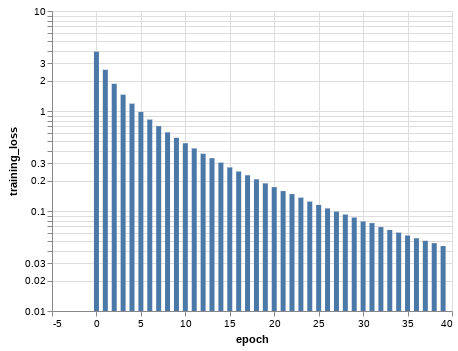

In [15]:
import altair as alt

df_loss = pd.DataFrame(enumerate(training_losses), columns=["epoch", "training_loss"])
alt.Chart(df_loss).mark_bar().encode(alt.X("epoch"), alt.Y("training_loss", scale=alt.Scale(type="log")))

And because we're paranoid types, let's check a prediction.

In [16]:
with torch.no_grad():
    logits = model.forward(**next(iter(dataloader)))
logits

tensor([[ 3.6188, -9.1918, -7.8617, -3.7270, -7.1823, -5.0832],
        [ 4.5565, -5.7671, -6.7461, -7.7732, -6.8886, -7.4012]])

The positive sample gets a positive score and the negatives get negative scores. Super.

We should be able get the paragraph vectors for the documents and do things like check these for similarity to one another.

In [17]:
from sklearn.preprocessing import normalize

def most_similar(paragraph_matrix, index):
    pm = normalize(paragraph_matrix, norm="l2")  # in a smarter implementation we would cache this somewhere
    sims = np.dot(pm, pm[index,:])
    return pd.DataFrame(enumerate(sims), columns=["doc_id", "similarity"])

most_similar(model.paragraph_matrix.data, 0) # TODO something wrong with this?

,doc_id,similarity
0,0,1.000000
1,1,0.258003
2,2,0.036349
3,3,0.045620


It's not particularly illuminating for our tiny set of dummy data though. We can also use PCA to reduce our n-dimensional paragraph vectors to 2 dimensions and see if they are clustered nicely.

2-component PCA, explains 38.73% of variance


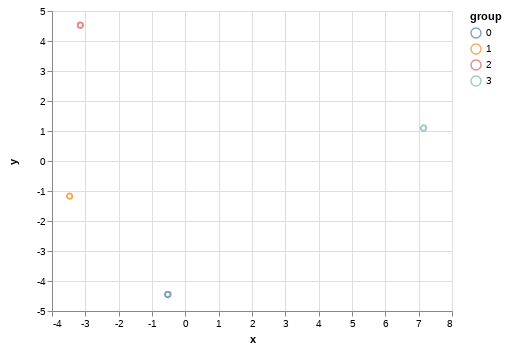

In [18]:
from sklearn.decomposition import PCA

def pca_2d(paragraph_matrix, groups):
    pca = PCA(n_components=2)
    reduced_dims = pca.fit_transform(paragraph_matrix)
    print(f"2-component PCA, explains {sum(pca.explained_variance_):.2f}% of variance")
    df = pd.DataFrame(reduced_dims, columns=["x", "y"])
    df["group"] = groups
    return df

example_2d = pca_2d(model.paragraph_matrix.data, ["0","1","2","3"])
alt.Chart(example_2d).mark_point().encode(x="x", y="y", color="group")

Not much to see on such a tiny dataset without any labelled groups.

Running this on some bigger data
--------------------------------

We'll use the BBC's dataset. The dataset was created by Derek Greene at UCD and all articles are copyright Auntie. I've munged it into a file per topic.

In [19]:
dfs = []
for document_set in ("sport",
                     "business",
                     "politics", 
                     "tech", 
                     "entertainment"):
    df_ = pd.read_csv(f"data/bbc/{document_set}.csv.bz2", encoding="latin1")
    df_ = tokenize_text(df_)
    df_["group"] = document_set
    dfs.append(df_)

bbc_df = pd.concat(dfs)
bbc_df[:4]

,text,tokens,group
0,Claxton hunting first major medal British hur...,"[claxton, hunting, first, major, medal, britis...",sport
1,O'Sullivan could run in Worlds Sonia O'Sulliv...,"[could, run, in, worlds, sonia, has, indicated...",sport
2,Greene sets sights on world title Maurice Gre...,"[greene, sets, sights, on, world, title, mauri...",sport
3,IAAF launches fight against drugs The IAAF - ...,"[iaaf, launches, fight, against, drugs, the, i...",sport


In [20]:
bbc_vocab = Vocab([tok for tokens in bbc_df.tokens for tok in tokens])

bbc_df = clean_tokens(bbc_df, bbc_vocab)

print(f"Dataset comprises {len(bbc_df)} documents and {len(bbc_vocab.words)} unique words")

Dataset comprises 2225 documents and 19063 unique words


In [21]:
bbc_noise = NoiseDistribution(bbc_vocab)
bbc_examples = list(example_generator(bbc_df, context_size=5, noise=bbc_noise, n_negative_samples=5, vocab=bbc_vocab))

In [22]:
bbc_dataset = NCEDataset(bbc_examples)
bbc_dataloader = DataLoader(bbc_dataset, batch_size=1024, drop_last=True, shuffle=True)  # TODO could tolerate a larger batch size

bbc_model = DistributedMemory(vec_dim=50,
                              n_docs=len(bbc_df),
                              n_words=len(bbc_vocab.words))

In [23]:
bbc_training_losses = train(bbc_model, bbc_dataloader, epochs=40, lr=1e-3)

Epochs: 100%|██████████| 40/40 [18:58<00:00, 28.35s/it]


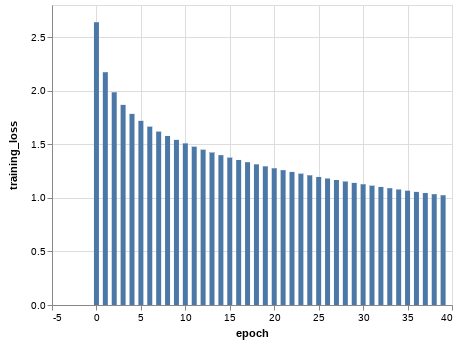

In [24]:
alt.Chart(pd.DataFrame(enumerate(bbc_training_losses), columns=["epoch", "training_loss"])).mark_bar().encode(x="epoch", y="training_loss")

Let's take a look at the reduced dimensionality paragraph vectors.

2-component PCA, explains 2.70% of variance


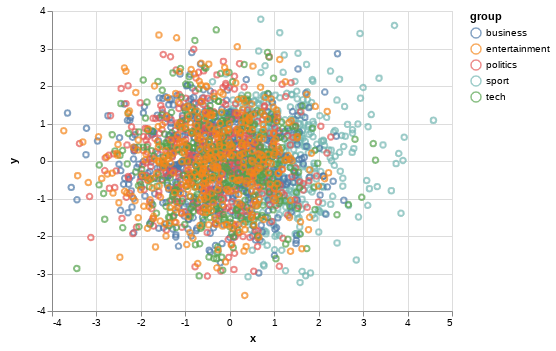

In [25]:
bbc_2d = pca_2d(bbc_model.paragraph_matrix.data, bbc_df.group.to_numpy())
alt.Chart(bbc_2d).mark_point().encode(x="x", y="y", color="group")

These results aren't great, but we can see the beginnings of separation. If we look at just two topics it becomes more obvious.

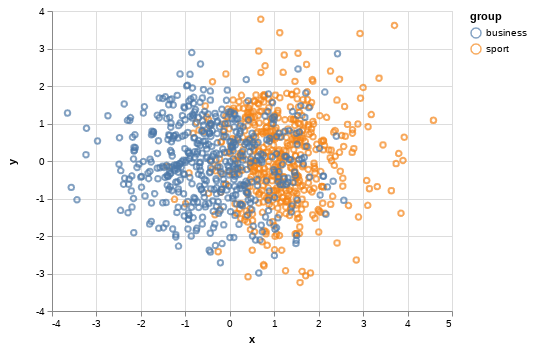

In [26]:
alt.Chart(bbc_2d[bbc_2d["group"].isin(["sport", "business"])]).mark_point().encode(x="x", y="y", color="group")